# **MIT 6.5940 EfficientML.ai Fall 2023 Lab 3: Neural Architecture Search**
by MIT HAN Lab


## Introduction

This colab notebook provides code and a framework for Lab 3: neural architecture search. In this lab, you will learn how to search for a tiny neural network that can run efficiently on a microcontroller. You can work out your solutions here.

Please fill out this [feedback form](https://forms.gle/bVWGf3DUNL4ShJ6N7) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!

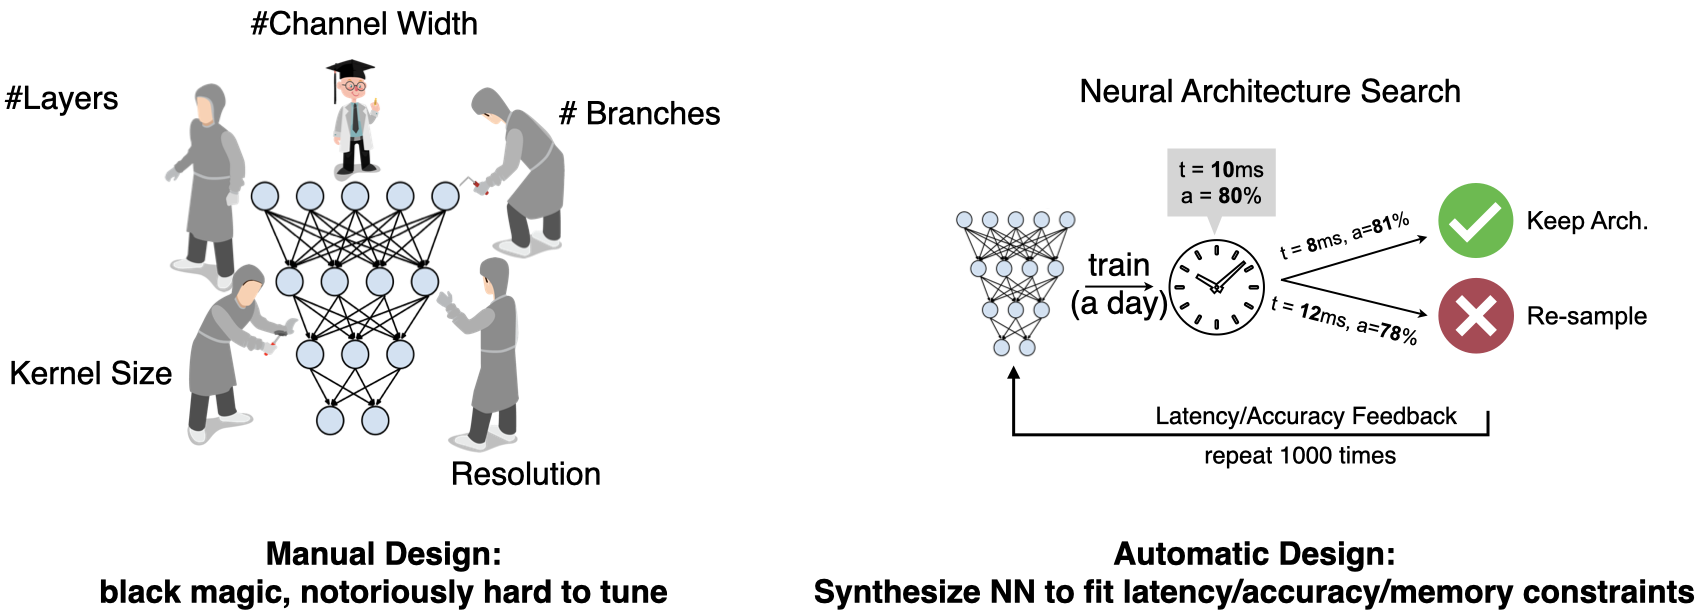

Over a long period of time, researchers manually design neural network architectures. The design space of NN architectures is very large: it includes #layers, #channel width, #branches, kernel sizes and input resolutions. As a result, tuning these design knobs manually is notoriously hard. **Neural architecture search**, or **NAS**, on the other hand, can help researchers automatically tune these design knobs under various type of efficiency and accuracy constraints. As a result, it greatly saves engineering cost in NN design and helps democratize AI. In this lab, we are going to walk you through neural architecture search from scratch.

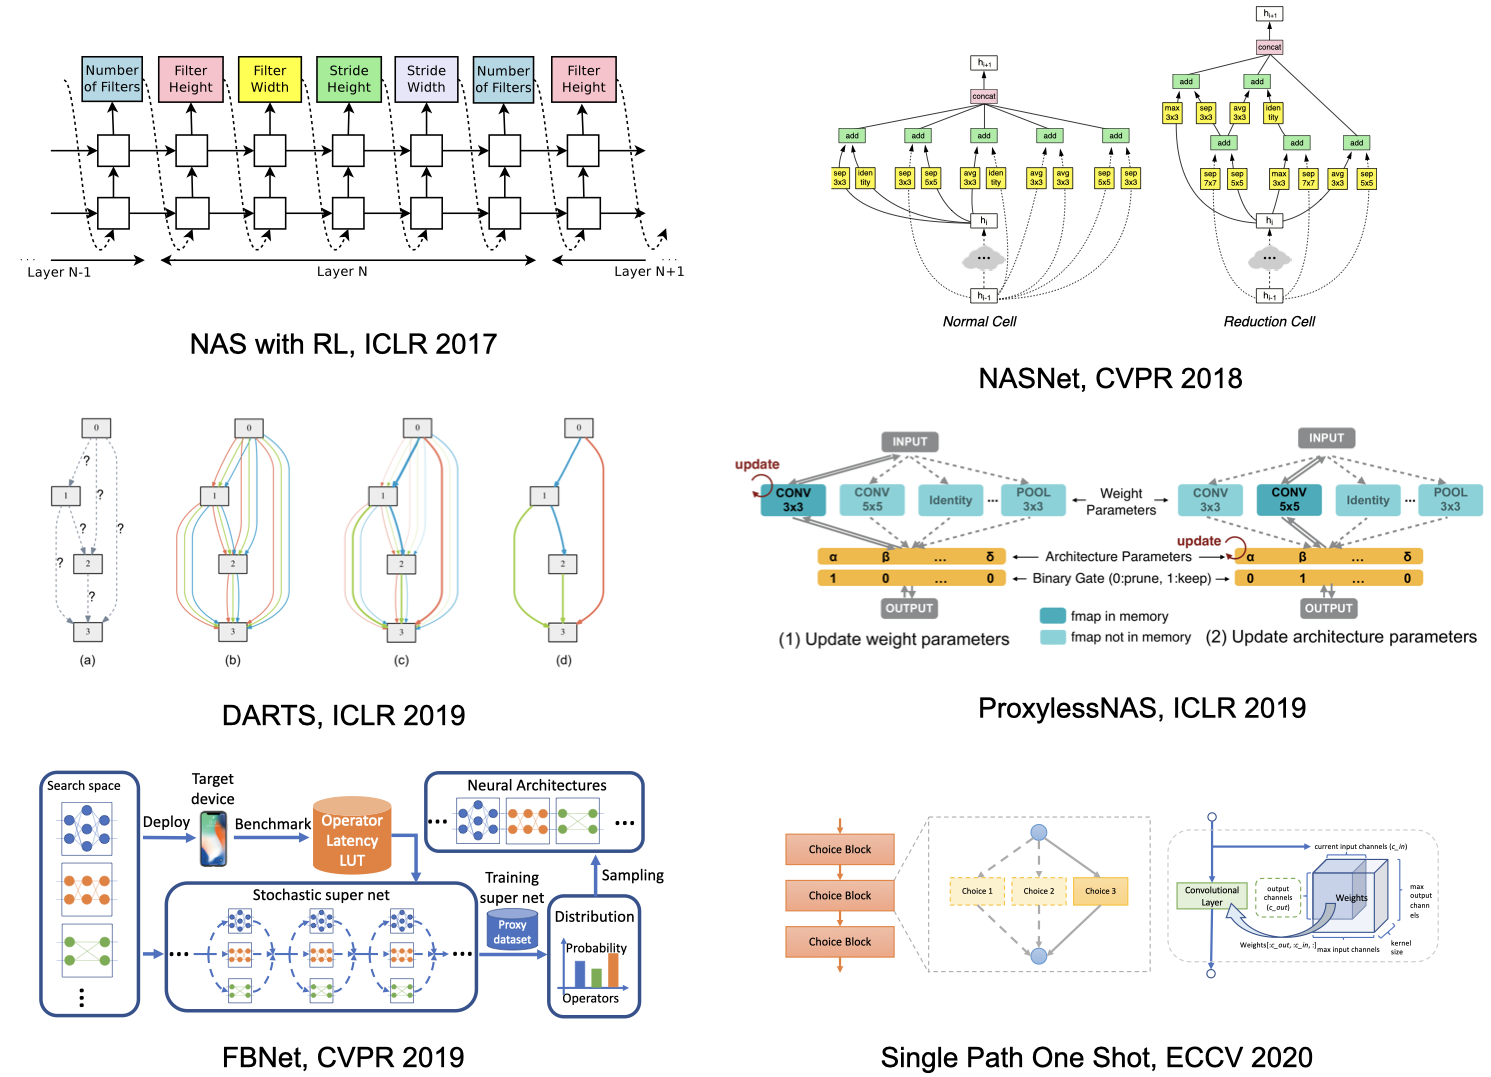

Early NAS methods train candidate network in the design space exhaustively and use **RNN-based controllers** with reinforcement learning to optimize the sampling strategy. The representative methods include [Neural Architecture Search with Reinforcement Learning](https://arxiv.org/abs/1611.01578), [NASNet](https://arxiv.org/abs/1707.07012) and [MNASNet](https://arxiv.org/abs/1807.11626). These methods are usually very computationally expensive because each candidate network has to be trained from scratch such that the RNN-based controller can get the reward signal (which is the accuracy of the candidate network).

Later, researchers develop **differentiable NAS** methods such as [DARTS](https://arxiv.org/abs/1806.09055), [ProxylessNAS](https://arxiv.org/abs/1812.00332) and [FBNet](https://arxiv.org/abs/1812.03443) that greatly reduces the total cost of training candidate networks. DARTS model the output of each layer as a weighted average of outputs from different candidate operations, and ProxylessNAS further reduces the memory cost of DARTS by keeping only two paths instead of all paths in the memory. Later **one-shot** methods such as [Single Path One Shot](https://arxiv.org/abs/1904.00420) further notice that it is possible to keep only one path at a time during the training process.

Albeit being much more efficient than controller-based methods, differentiable NAS and one-shot NAS still requires running the entire training, search and finetune pipeline everytime we design a new neural network. This brings about large cost (typically 200-300 GPU hours for the ImageNet dataset) for model specialization considering the large amount of edge devices (e.g. there are [> 20 billion IoT devices](https://www.statista.com/statistics/471264/iot-number-of-connected-devices-worldwide/) till 2018).

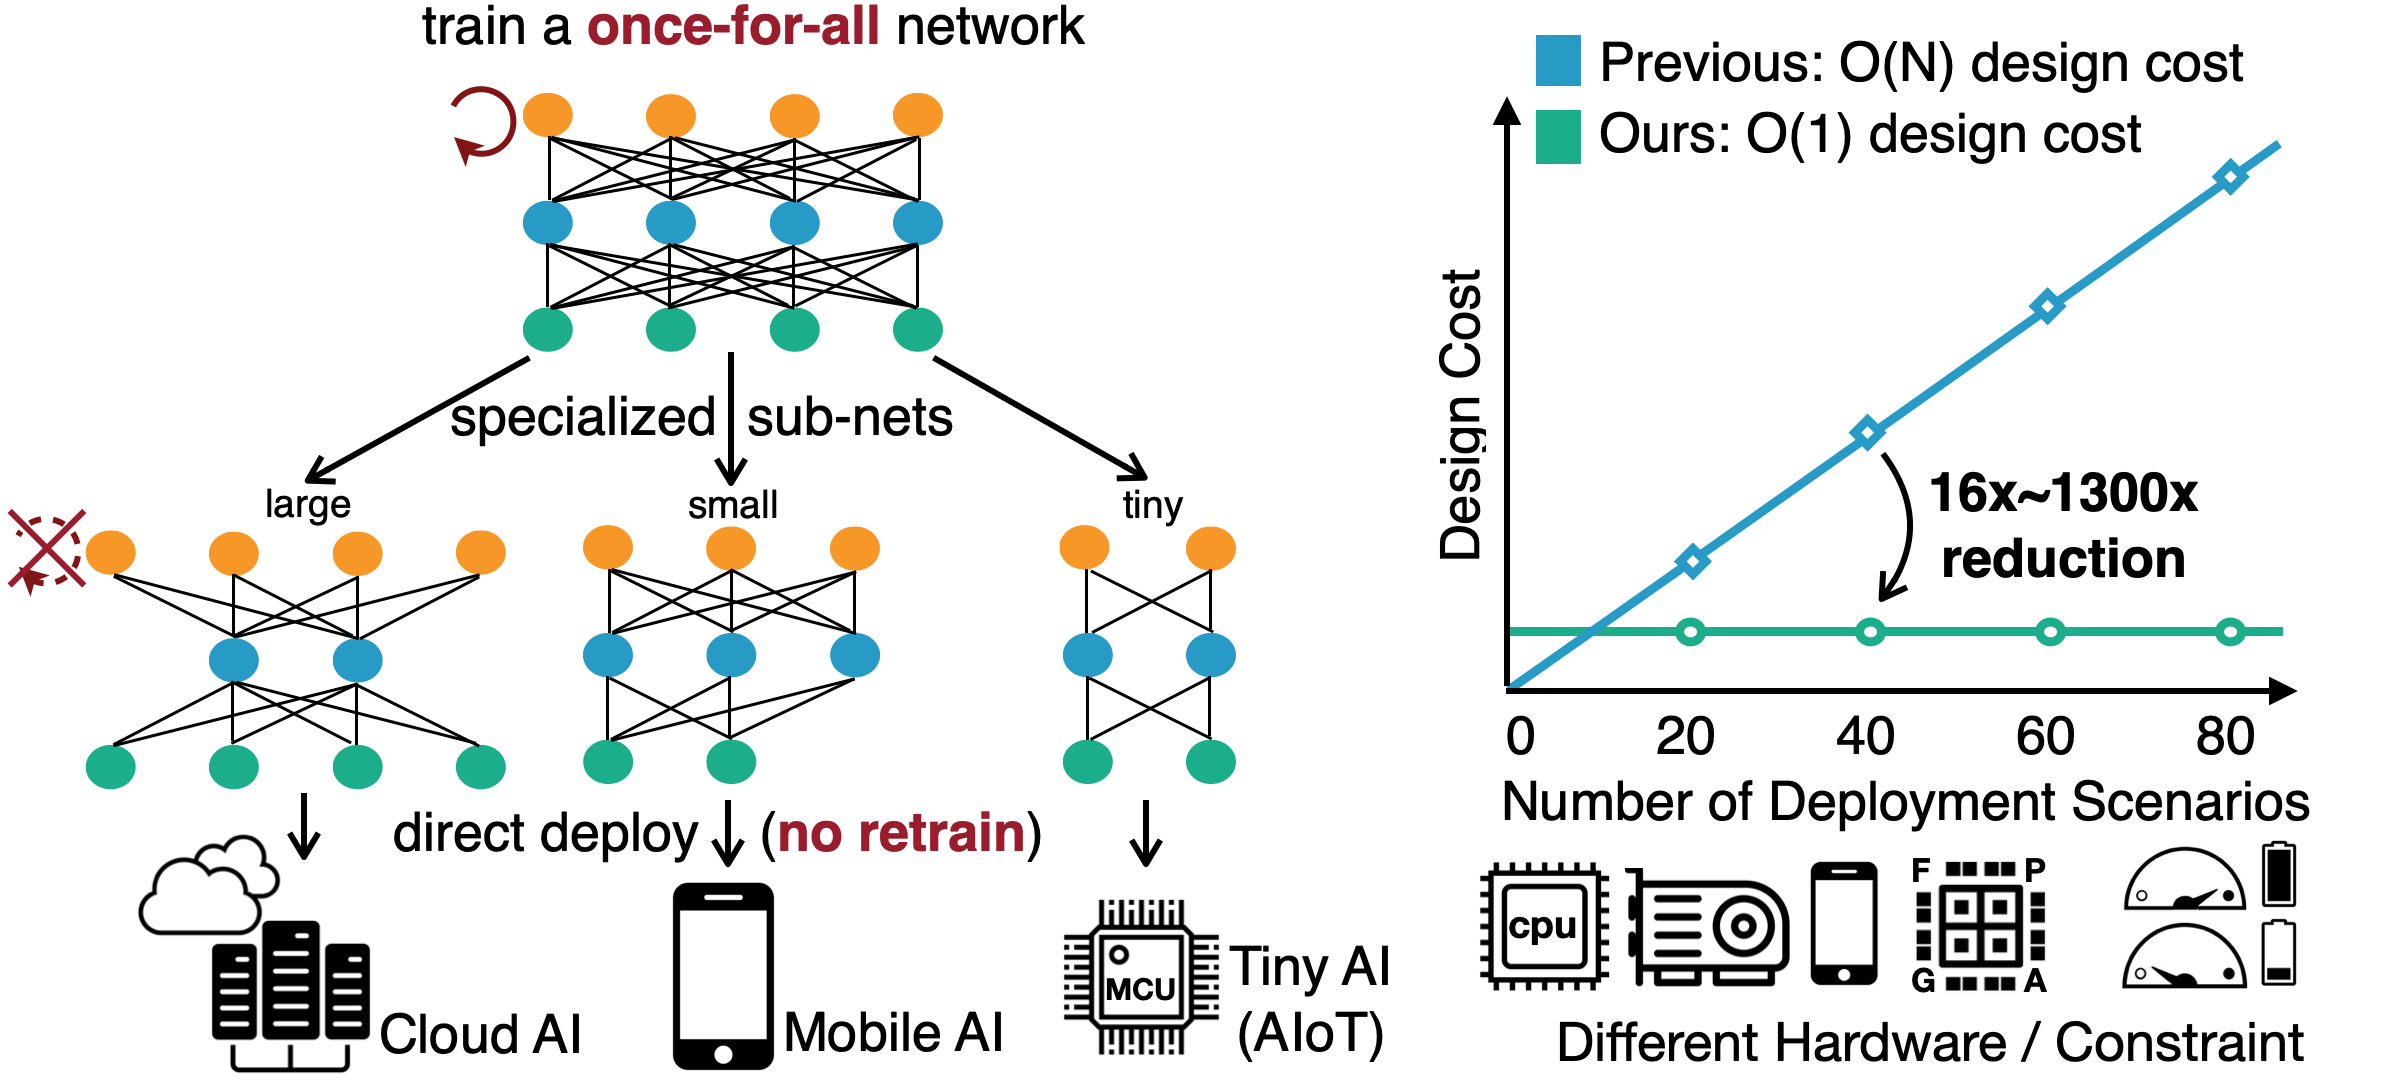

In this lab, we therefore refer to [Once for All](https://arxiv.org/abs/1908.09791) (OFA), a method that can greatly reduce the cost of specialize NN architectures for different devices. OFA trains a large **super network** that contains all **sub-networks** within the design space. If we directly extract the sub-networks from the super network, they can achieve similar-level of accuracy compared with training from scratch. As such, OFA supports direct deployment with **no retrain**.

Furthermore, OFA introduces **accuracy and efficiency predictors** to further reduce the evaluation cost during architecture search. Intuitively the accuracy of a sub-network requires running inference on the entire holdout validation set, which can take around 1 minute on ImageNet. OFA, instead, collects a large amount of (architecture, accuracy) pairs beforehand and trains a regression model to **predict** the accuracy during search. This greatly reduces the cost to get the accuracy feedback from 1 minute to less than 1 second for each sub-network. Similar idea can also be applied to efficiency predictors, where the evaluation of **latency** are usually very slow since we have to run the forward pass of the candidate network for many times.

In this lab, you will study how to search for efficient networks that can run on extremely resource-constrained microcontrollers with **OFA** and **predictors**. Microcontrollers are low-cost, low-power hardware. They are widely deployed and have wide applications.

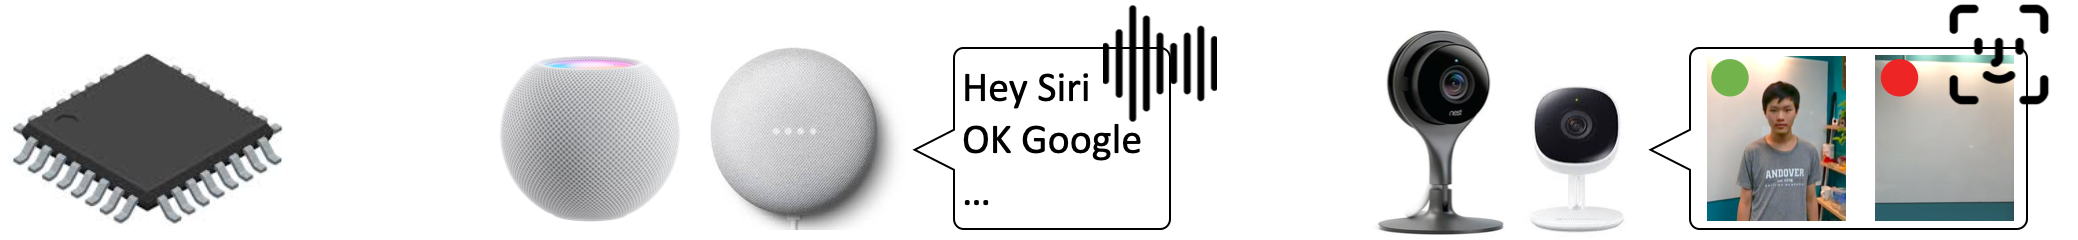

But the tight memory budget (50,000x smaller than GPUs) makes deep learning deployment difficult.

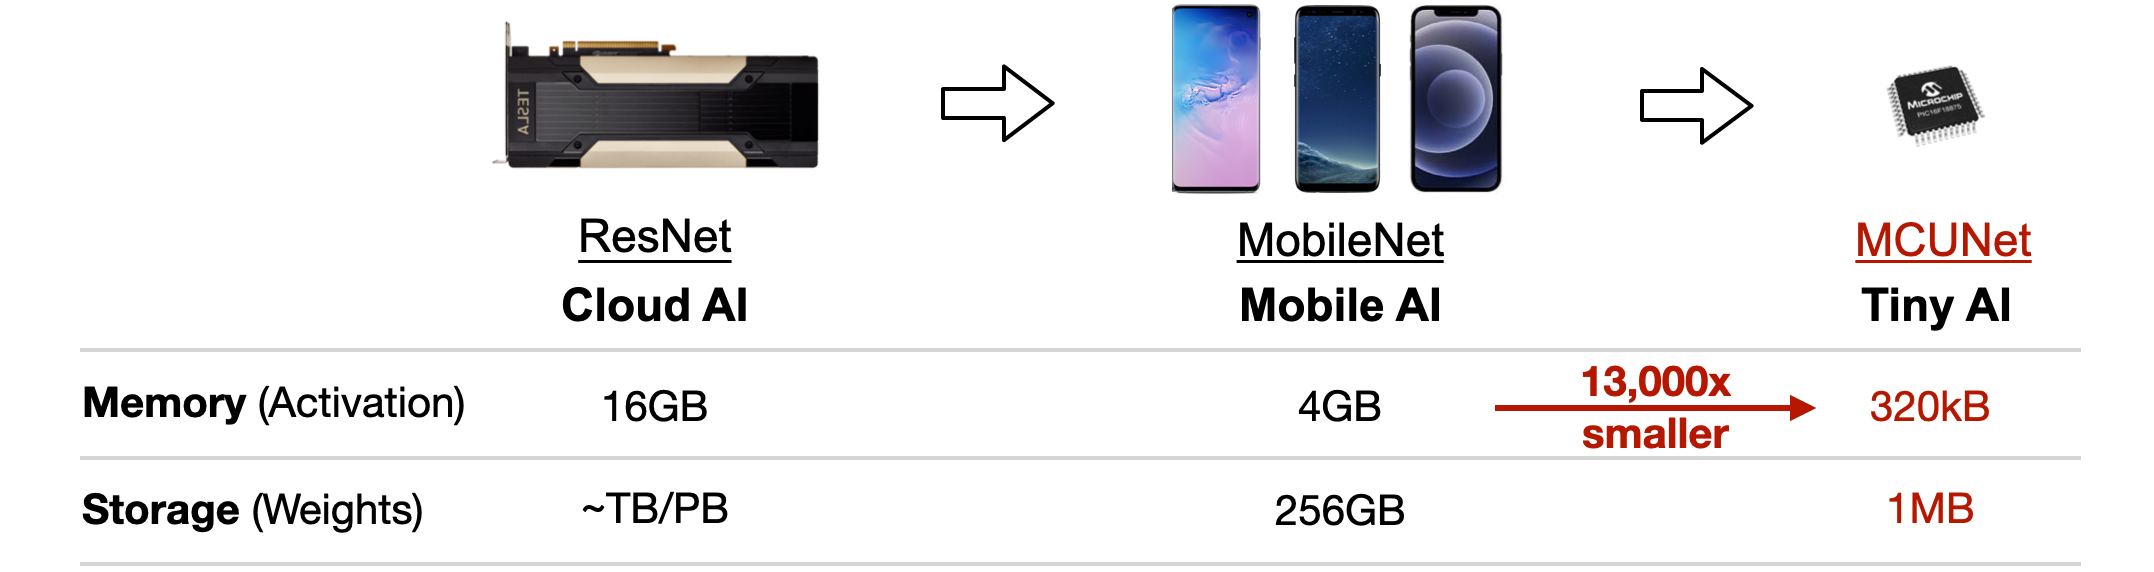

There are 2 main sections: **accuracy & efficiency predictors** and **architecture search**.

- For predictors, there are ***4*** questions in total. There is one question (5 pts) in the **Getting Started** section and the other three questions (30 pts) are in the **Predictors** section.
- For architecture search, there are ***?*** questions in total.

First, install the required packages and download the [**Visual Wake  Words** dataset](https://arxiv.org/abs/1906.05721) that will be used in this lab.

In [1]:
print("Cleanning up workspace ...")
!rm -rf *
print("Installing graphviz ...")
!sudo apt-get install graphviz 1>/dev/null
print("Downloading MCUNet codebase ...")
!wget https://www.dropbox.com/s/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip?dl=0 >/dev/null
!unzip mcunetv2-dev-main.zip* 1>/dev/null
!mv mcunetv2-dev-main/* . 1>/dev/null
print("Downloading VWW dataset ...")
!wget https://www.dropbox.com/s/169okcuuv64d4nn/data.zip?dl=0 >/dev/null
print("Unzipping VWW dataset ...")
!unzip data.zip* 1>/dev/null
print("Installing thop and onnx ...")
!pip install thop 1>/dev/null
!pip install onnx 1>/dev/null

Cleanning up workspace ...
Installing graphviz ...
--2023-11-14 01:32:51--  https://www.dropbox.com/s/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip [following]
--2023-11-14 01:32:52--  https://www.dropbox.com/s/raw/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb40a6eb14b5026e24365d4bf22.dl.dropboxusercontent.com/cd/0/inline/CHdIAoQwKxgp1rt9t2_N85YYlh5iRBQZandF9xEwnPHKj_D5yT1axspdz-BWhbHYG6fDRWnm2tS4wYUu1UOJRoxdhMf1OlS_VA-sTM2_qZP1H49HiJZQyDYLwA1xQHejzuCRD1yHgQvSztdKOdCPbDXE/file# [following]
--2023-11-14 01:32:53--  https://ucb40a6eb14b5026e24365d4bf22.dl.dropboxusercontent.com/cd/0/inline/CHdIAoQwKxgp1rt9

In [2]:
import argparse
import json
from PIL import Image
from tqdm import tqdm
import copy
import math
import numpy as np
import os
import random
import torch
from torch import nn
from torchvision import datasets, transforms
from mcunet.tinynas.search.accuracy_predictor import (
    AccuracyDataset,
    MCUNetArchEncoder,
)

from mcunet.tinynas.elastic_nn.networks.ofa_mcunets import OFAMCUNets
from mcunet.utils.mcunet_eval_helper import calib_bn, validate
from mcunet.utils.arch_visualization_helper import draw_arch


%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## **Getting Started: Super Network and the VWW dataset (1 Question, 5 pts)**

In this lab, we will be using the **[MCUNetV2](https://arxiv.org/abs/2110.15352)** *super network* trained in an **once-for-all (OFA)** manner. Recall that *super network* is a randomized large neural network that contains all candidate subnets within the design space. We can directly extract the subnets from the super network and evaluate their accuracy. The accuracy can be further used as a feedback signal to guide neural network design. The advantage of OFA super network is that the directly extracted subnets can achieve similar (or even better) performance compared with training from scratch.

MCUNetV2 is a family of efficiency neural networks tailored for resource-constrained microntrollers. It utilizes patch-based inference, receptive field redistribution and system-NN co-design and greatly improves the accuracy-efficiency tradeoff of [MCUNet](https://arxiv.org/abs/2007.10319).

Let's first visualize some samples in the VWW dataset. This is a binary image classficiation (whether people is present in the image) dataset subsampled from [Microsoft COCO](https://arxiv.org/abs/1405.0312). We first define a function to set up a dataloader over the validation set.

Note: The function `build_val_data_loader` has an argument `split`. We use `split = 0` (default value) to represent the validation set (cannot be directly used for architecture search), and `split = 1` will be used as a holdout minival set (used to generate the accuracy dataset and calibrate BN parameters).

In [3]:
def build_val_data_loader(data_dir, resolution, batch_size=128, split=0):
    # split = 0: real val set, split = 1: holdout validation set
    assert split in [0, 1]
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    kwargs = {"num_workers": min(8, os.cpu_count()), "pin_memory": False}

    val_transform = transforms.Compose(
        [
            transforms.Resize(
                (resolution, resolution)
            ),  # if center crop, the person might be excluded
            transforms.ToTensor(),
            normalize,
        ]
    )
    val_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

    val_dataset = torch.utils.data.Subset(
        val_dataset, list(range(len(val_dataset)))[split::2]
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, **kwargs
    )
    return val_loader

Using that dataloader builder, we are able to navigate through the VWW validation set. You can run the following cell for several times to see different images in the dataset.

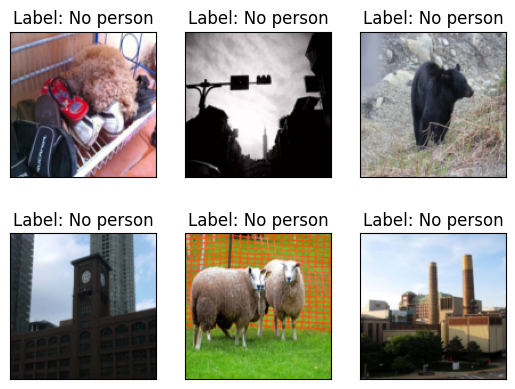

In [4]:
data_dir = "data/vww-s256/val"

val_data_loader = build_val_data_loader(data_dir, resolution=128, batch_size=1)

vis_x, vis_y = 2, 3
fig, axs = plt.subplots(vis_x, vis_y)

num_images = 0
for data, label in val_data_loader:
    img = np.array((((data + 1) / 2) * 255).numpy(), dtype=np.uint8)
    img = img[0].transpose(1, 2, 0)
    if label.item() == 0:
        label_text = "No person"
    else:
        label_text = "Person"
    axs[num_images // vis_y][num_images % vis_y].imshow(img)
    axs[num_images // vis_y][num_images % vis_y].set_title(f"Label: {label_text}")
    axs[num_images // vis_y][num_images % vis_y].set_xticks([])
    axs[num_images // vis_y][num_images % vis_y].set_yticks([])
    num_images += 1
    if num_images > vis_x * vis_y - 1:
        break

plt.show()

Cool, now you have a basic idea about the dataset. Let's then construct the OFA super network! The `OFAMCUNets` super network is composed of $>10^{19}$ subnets in the MCUNetV2 design space. The subnets are composed of [inverted MobileNet blocks](https://arxiv.org/abs/1801.04381) with different kernel sizes (3, 5, 7) and expand ratios (3, 4, 6). The OFA super network also allows elastic depths (base depth to base_depth + 2) for all network stages. Finally, the super network supports global channel scaling (specified by `width_mult_list`) by 0.5$\times$, 0.75$\times$ or 1.0$\times$.

In [5]:
device = "cuda:0"
ofa_network = OFAMCUNets(
    n_classes=2,
    bn_param=(0.1, 1e-3),
    dropout_rate=0.0,
    base_stage_width="mcunet384",
    width_mult_list=[0.5, 0.75, 1.0],
    ks_list=[3, 5, 7],
    expand_ratio_list=[3, 4, 6],
    depth_list=[0, 1, 2],
    base_depth=[1, 2, 2, 2, 2],
    fuse_blk1=True,
    se_stages=[False, [False, True, True, True], True, True, True, False],
)

ofa_network.load_state_dict(
    torch.load("vww_supernet.pth", map_location="cpu")["state_dict"], strict=True
)

ofa_network = ofa_network.to(device)

We then verify that the checkpoint is correctly loaded. We will sample some networks in the MCUNetV2 design space and evaluate its accuracy on the VWW dataset. The evaluation will take less than one minutes, and you are expected to see an accuracy around 83.6-88.7%. As you can see, we can directly extract these subnets from the design space and get their accuracy very quickly without **training**. This is a unique advantage brought by once-for-all (OFA) super networks.

Let's first define a helper function `evaluate_sub_network` that testes the accuracy of a sub network directly extracted from the super network.

In [6]:
from mcunet.utils.pytorch_utils import count_peak_activation_size, count_net_flops, count_parameters

def evaluate_sub_network(ofa_network, cfg, image_size=None):
    if "image_size" in cfg:
        image_size = cfg["image_size"]
    batch_size = 128
    # step 1. sample the active subnet with the given config.
    ofa_network.set_active_subnet(**cfg)
    # step 2. extract the subnet with corresponding weights.
    subnet = ofa_network.get_active_subnet().to(device)
    # step 3. calculate the efficiency stats of the subnet.
    peak_memory = count_peak_activation_size(subnet, (1, 3, image_size, image_size))
    macs = count_net_flops(subnet, (1, 3, image_size, image_size))
    params = count_parameters(subnet)
    # step 4. perform BN parameter re-calibration.
    calib_bn(subnet, data_dir, batch_size, image_size)
    # step 5. define the validation dataloader.
    val_loader = build_val_data_loader(data_dir, image_size, batch_size)
    # step 6. validate the accuracy.
    acc = validate(subnet, val_loader)
    return acc, peak_memory, macs, params

We also provide a handly helper function to visualize the architecture of the subnets. The function takes in the configuration of the subnet and returns an image representing the architecture.

In [7]:
def visualize_subnet(cfg):
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], cfg["image_size"], out_name="viz/subnet")
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    plt.imshow(im)
    plt.show()

Now, let's visualize some subnets and evaluate them on the VWW dataset! We provide an example to randomly sample a subnet from the design space, and get its accuracy, macs, parameters on the VWW dataset. We also visualize the architecture using `visualize_subnet`.

In the architecture visualization, the legend of each block `MBConv{e}-{k}x{k}` means that the current block is a mobile inverted block with expand ratio `e` and the kernel size of the depthwise convolution layer is `k`. Different colors of the blocks indicate different kernel sizes, and gray blocks are network stage dividers. Different widths for the blocks indicate different expand ratios. We also annotate the output resolution close to each block.

Note that we assume that the image resolution is fixed to be 96. Feel free to add another cell below and play with the input resolution.

Hint: you can change the `sample_function` argument of the `sample_active_subnet` method to control the sampling process.

Validate: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s, loss=0.311, top1=86.8]


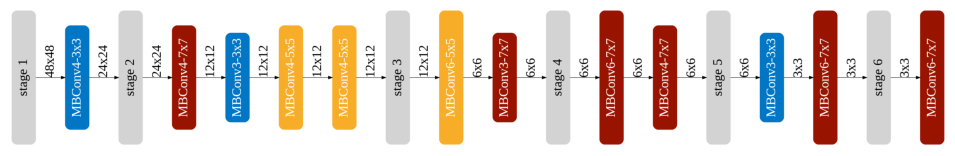

The accuracy of the sampled subnet: #params= 1.2M, accuracy= 86.8%.


Validate: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s, loss=0.29, top1=88.6]


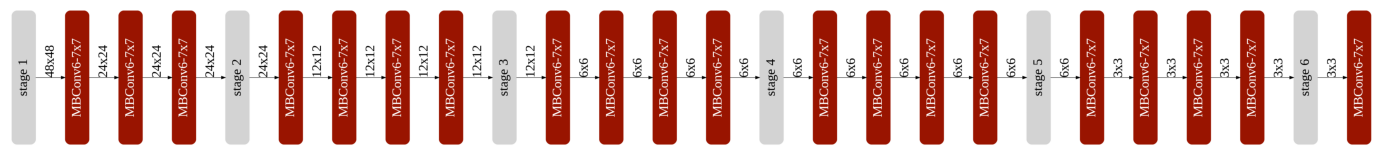

The largest subnet: #params= 2.5M, accuracy= 88.6%,  MAC=79416432.0,  peak memory=276480.0.


Validate: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s, loss=0.379, top1=83.4]


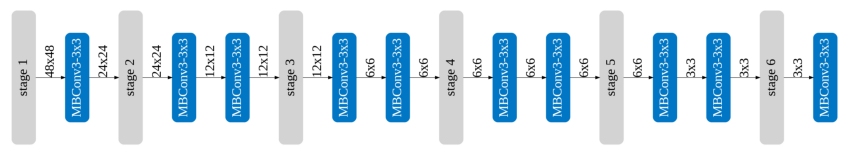

The smallest subnet: #params= 0.3M, accuracy= 83.4%,    MAC=8302128.0,  peak memory=73728.0.


In [8]:
image_size = 96

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
visualize_subnet(cfg)
print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, largest_cfg)
visualize_subnet(largest_cfg)
print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%,  MAC={macs},  peak memory={peak_memory}.")

smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
visualize_subnet(smallest_cfg)
print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%,    MAC={macs},  peak memory={peak_memory}.")

### Question 1 (5 pts): Design space exploration.

Try manually sample different subnets by running the cell above multiple times. You can also vary the input resolution. Talk about your findings.

Hint: which dimension plays the most important role for the accuracy?

**Answer:** Resolution

## **Part 1. Predictors (3 Questions, 30 pts)**

Neural architecture search requires sampling a large amount of sub-networks from the OFA supernet and evaluate the performance of these sub-networks. Such performance evaluation is time-consuming.


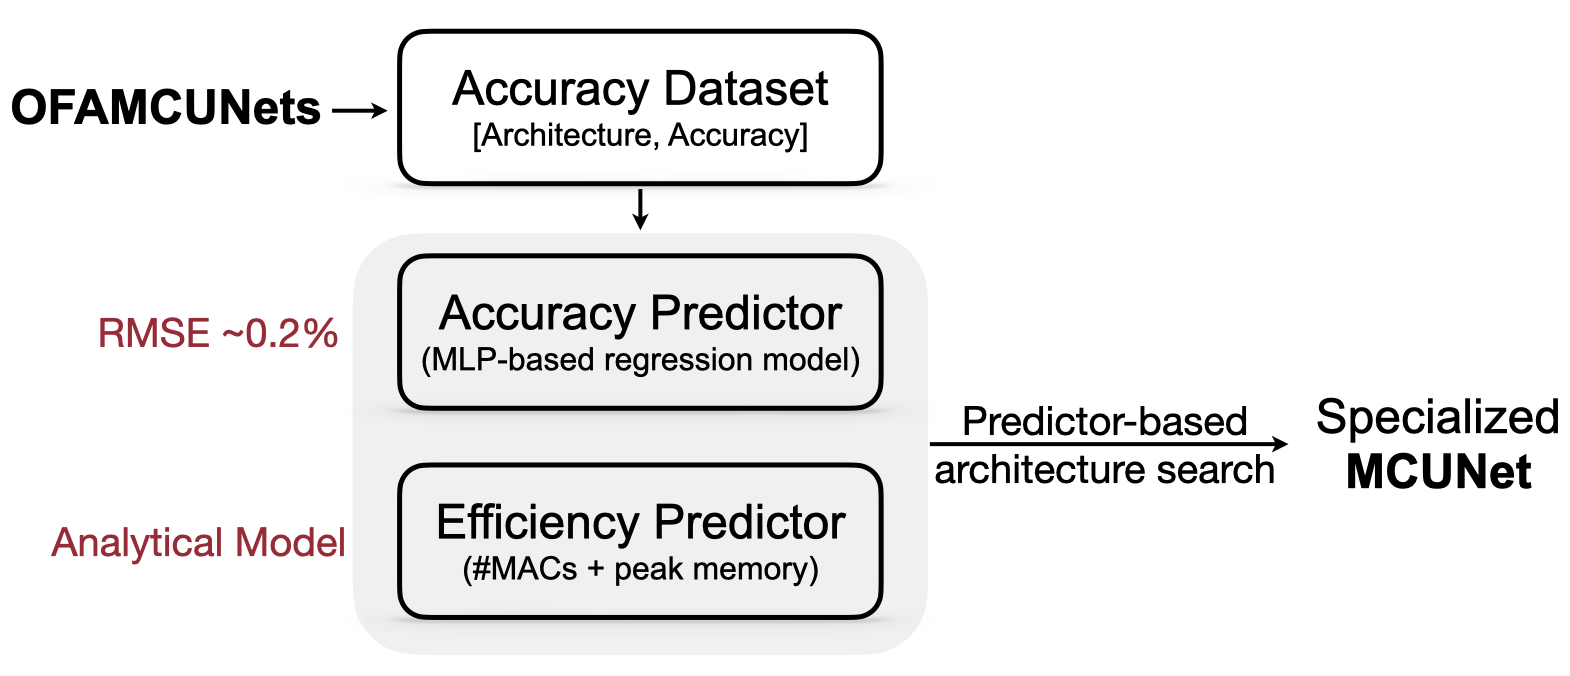

In this lab, we explore very fast neural network search with **efficiency predictors** and **accuracy predictors**.

### Question 2 (10 pts): Implement the efficiency predictor.

For the efficiency predictor, we use an hook-based analytical model to count the #MACs and peak memory consumption of a given network. Let's build it from scratch using our provided APIs.

Specifically, we define a class called `AnalyticalEfficiencyPredictor`. There are two major functions in this class, `get_efficiency` and `satisfy_constraint`.

The function `get_efficiency` takes in the subnet configuration and returns the #MACs and peak memory of the given subnet. Here, we assume the unit for the #MACs is million and the unit of the peak memory consumption is KB.

Hint: take a look at the `evaluate_sub_network` function above. Let's use `count_net_flops` to get the MACs of the network and `count_peak_activation_size` to get the activation size of the network.


In [9]:
class AnalyticalEfficiencyPredictor:
    def __init__(self, net):
        self.net = net

    def get_efficiency(self, spec: dict):
        self.net.set_active_subnet(**spec)
        subnet = self.net.get_active_subnet()
        if torch.cuda.is_available():
            subnet = subnet.cuda()
        ############### YOUR CODE STARTS HERE ###############
        # Hint: take a look at the `evaluate_sub_network` function above.
        # Hint: the data shape is (batch_size, input_channel, image_size, image_size)
        batch_size = 128
        if "image_size" in spec:
          image_size = cfg["image_size"]
        data_shape =(batch_size,3,image_size,image_size)
        macs =count_net_flops(subnet, (1, 3, image_size, image_size))
        peak_memory =count_peak_activation_size(subnet, (1, 3, image_size, image_size))
        ################ YOUR CODE ENDS HERE ################

        return dict(millionMACs=macs / 1e6, KBPeakMemory=peak_memory / 1024)

    def satisfy_constraint(self, measured: dict, target: dict):
        for key in measured:
            # if the constraint is not specified, we just continue
            if key not in target:
                continue
            # if we exceed the constraint, just return false.
            if measured[key] > target[key]:
                return False
        # no constraint violated, return true.
        return True

Let's test your implementation for the analytical efficiency predictor by examining the returned values for the smallest and largest subnets we just evaluated a while ago. The results from the efficiency predictor should match with the previous results.

In [10]:
efficiency_predictor = AnalyticalEfficiencyPredictor(ofa_network)

image_size = 96
# Print out the efficiency of the smallest subnet.
smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
eff_smallest = efficiency_predictor.get_efficiency(smallest_cfg)

# Print out the efficiency of the largest subnet.
largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
eff_largest = efficiency_predictor.get_efficiency(largest_cfg)

print("Efficiency stats of the smallest subnet:", eff_smallest)
print("Efficiency stats of the largest subnet:", eff_largest)

Efficiency stats of the smallest subnet: {'millionMACs': 8.302128, 'KBPeakMemory': 72.0}
Efficiency stats of the largest subnet: {'millionMACs': 79.416432, 'KBPeakMemory': 270.0}


### Question 3 (10 pts): Implement the accuracy predictor.

For the accuracy predictor, it predicts the classification accuracy of a given sub-network on the VWW dataset so that we do **NOT** need to run costly inference every time when we encounter a new subnet during architecture search. Such an accuracy predictor is an MLP (multi-layer perception) model trained on an accuracy dataset built with the OFA network. The inference of an MLP network takes only a few milliseconds, thus the accuracy predictor can speedup the search process by **orders of magnitude**.

The accuracy predictor takes in the architecture of a sub-network and predicts its accuracy on the VWW dataset. Since it is an MLP network, the sub-network must be encoded into a **vector**. In this lab, we provide a class `MCUNetArchEncoder` to perform such conversion from **sub-network architecture** to a **binary vector**.

In [11]:
image_size_list = [96, 112, 128, 144, 160]
arch_encoder = MCUNetArchEncoder(
    image_size_list=image_size_list,
    base_depth=ofa_network.base_depth,
    depth_list=ofa_network.depth_list,
    expand_list=ofa_network.expand_ratio_list,
    width_mult_list=ofa_network.width_mult_list,
)

We generated an accuracy dataset beforehand, which is a collection of `[architecture, accuracy]` pairs stored under the `acc_datasets` folder.

With the architecture encoder, you are now required define the accuracy predictor, which is a multi-layer perception (MLP) network with 400 channels per intermediate layer. For simplicity, we fix the number of layers to be **3**. Please implement this MLP network in the following cell.

In [19]:
class AccuracyPredictor(nn.Module):
    def __init__(
        self,
        arch_encoder,
        hidden_size=400,
        n_layers=3,
        checkpoint_path=None,
        device="cuda:0",
    ):
        super(AccuracyPredictor, self).__init__()
        self.arch_encoder = arch_encoder
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        layers = []

        ############### YOUR CODE STARTS HERE ###############
        # Let's build an MLP with n_layers layers.
        # Each layer (nn.Linear) has hidden_size channels and
        # uses nn.ReLU as the activation function.
        # Hint: You can assume that n_layers is fixed to be 3, for simplicity.
        # Hint: the input dimension of the first layer is not hidden_size.
        #       use self.arch_encoder.n_dim to get the input dimension
        for i in range(self.n_layers):
          if i == 0:
            layers.append(
                nn.Linear(self.arch_encoder.n_dim, self.hidden_size, bias=False)
            )
            layers.append(
                nn.ReLU()
            )
          else:
            layers.append(
                nn.Linear(self.hidden_size, self.hidden_size, bias=False)
            )
            layers.append(
                nn.ReLU()
            )
        ################ YOUR CODE ENDS HERE ################
        layers.append(nn.Linear(self.hidden_size, 1, bias=False))
        self.layers = nn.Sequential(*layers)
        self.base_acc = nn.Parameter(
            torch.zeros(1, device=self.device), requires_grad=False
        )

        if checkpoint_path is not None and os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location="cpu")
            if "state_dict" in checkpoint:
                checkpoint = checkpoint["state_dict"]
            self.load_state_dict(checkpoint)
            print("Loaded checkpoint from %s" % checkpoint_path)

        self.layers = self.layers.to(self.device)

    def forward(self, x):
        y = self.layers(x).squeeze()
        return y + self.base_acc

    def predict_acc(self, arch_dict_list):
        X = [self.arch_encoder.arch2feature(arch_dict) for arch_dict in arch_dict_list]
        X = torch.tensor(np.array(X)).float().to(self.device)
        return self.forward(X)

Let's print out the architecture of the `AccuracyPredictor` you just defined.

In [20]:
os.makedirs("pretrained", exist_ok=True)
acc_pred_checkpoint_path = (
    f"pretrained/{ofa_network.__class__.__name__}_acc_predictor.pth"
)
acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    checkpoint_path=None,
    device=device,
)
print(acc_predictor)

AccuracyPredictor(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=400, bias=False)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=400, bias=False)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=400, bias=False)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=1, bias=False)
  )
)


Let's first visualize some samples in the accuracy dataset in the following cell.

The accuracy dataset is composed of 50,000 `[architecture, accuracy]` pairs, where 40,000 of them are used as the training set and the rest 10,000 are used as validation set.

For **accuracy**, We calculate the average accuracy of all `[architecture, accuracy]` pairs on the accuracy dataset and define it as `base_acc`. For the accuracy predictor, instead of directly regressing the accuracy of each architecture, its training target is `accuracy - base_acc`. Since `accuracy - base_acc` is usually much smaller than `accuracy` itself, this can make training easier.

For **architecture**, each subnet within the design space is uniquely represented by a binary vector. The binary vector is a concatenation of the **one-hot representation** for both global parameters (*e.g.* input resolution, width multiplier) and parameters of each inverted MobileNet block (*e.g.* kernel sizes and expand ratios). Note that we prefer **one-hot** representations over **numerical** representations because all design hyperparameters are **discrete** values.

For example, our design space supports

```python
kernel_size = [3, 5, 7]
expand_ratio = [3, 4, 6]
```

Then, we represent `kernel_size=3` as `[1, 0, 0]`, `kernel_size=5` as `[0, 1, 0]`, and `kernel_size=7` as `[0, 0, 1]`. Similarly, for `expand_ratio=3`, it is written as `[1, 0, 0]`; `expand_ratio=4` is written as `[0, 1, 0]` and `expand_ratio=6` is written as `[0, 0, 1]`. The representation for each inverted MobileNet block is obtained by concatenating the kernel size embedding with the expand ratio embedding. Note that for skipped blocks, we use `[0, 0, 0]` to represent their kernel sizes and expand ratios. You will see a detailed explanation of the architecture-embedding correspondence after running the following cell.

Loading data: 100%|██████████| 50000/50000 [00:00<00:00, 78392.08it/s]


Train Size: 40000, Valid Size: 10000
The basic accuracy (mean accuracy of all subnets within the dataset is:  90.3%.
network embedding: [0 0 1 0 0 | 1 0 0 | 0 1 0 | 0 0 1 | 0 0 0 | 0 0 0 | 0 0 0 | 0 0 0 | 0 1 0 | 0 0 1 | 0 1 0 | 1 0 0 | 0 0 1 | 0 1 0 | 0 1 0 | 0 1 0 | 1 0 0 | 1 0 0 | 0 1 0 | 1 0 0 | 0 0 1 | 0 1 0 | 1 0 0 | 1 0 0 | 0 0 1 | 1 0 0 | 0 1 0 | 0 1 0 | 1 0 0 | 0 1 0 | 0 0 0 | 0 0 0 | 0 1 0 | 0 0 1 | 0 1 0 | 1 0 0 | 0 0 1 | 0 1 0 | 0 0 0 | 0 0 0 | 0 0 1 | 1 0 0]
image resolution embedding: [0 0 1 0 0] => image resolution: 128
width multiplier embedding: [1 0 0] => width multiplier: 0.5
**************************************************Stage1**************************************************
kernel size embedding: [0 1 0] => kernel size: 5; expand ratio embedding: [0 0 1] => expand ratio: 6
kernel size embedding: [0 0 0] expand ratio embedding: [0 0 0] => layer skipped.
kernel size embedding: [0 0 0] expand ratio embedding: [0 0 0] => layer skipped.
****************************

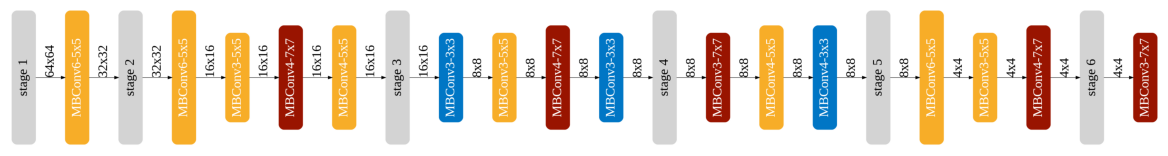

The accuracy of this subnet on the holdout validation set is:  90.7%.


In [21]:
acc_dataset = AccuracyDataset("acc_datasets")
train_loader, valid_loader, base_acc = acc_dataset.build_acc_data_loader(
    arch_encoder=arch_encoder
)

print(f"The basic accuracy (mean accuracy of all subnets within the dataset is: {(base_acc * 100): .1f}%.")

# Let's print one sample in the training set
sampled = 0
for (data, label) in train_loader:
    data = data.to(device)
    label = label.to(device)
    print("=" * 100)
    # dummy pass to print the divided encoding
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=False)
    # print out the architecture encoding process in detail
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=True)
    visualize_subnet(arch_encoding)
    print(f"The accuracy of this subnet on the holdout validation set is: {(label[0] * 100): .1f}%.")
    sampled += 1
    if sampled == 1:
        break


### Question 4 (10 pts): Complete the code for accuracy predictor training.


Now let's train the accuracy predictor using the dataset we provided! In this part, you are responsible for the implementation of the training and validation of your accuracy predictor. The training process will take roughly 1-2 minutes.

Hint: you may refer to Tutorial 2 on how to train a neural network with PyTorch.

In [22]:
criterion = torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(acc_predictor.parameters())
# the default value is zero
acc_predictor.base_acc.data += base_acc
for epoch in tqdm(range(10)):
    acc_predictor.train()
    for (data, label) in tqdm(train_loader, desc="Epoch%d" % (epoch + 1), position=0, leave=True):
        # step 1. Move the data and labels to device (cuda:0).
        data = data.to(device)
        label = label.to(device)
        ############### YOUR CODE STARTS HERE ###############
        # step 2. Run forward pass.
        pred = acc_predictor(data)
        # step 3. Calculate the loss.
        loss = criterion(pred,label)
        # step 4. Perform the backward pass.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ################ YOUR CODE ENDS HERE ################

    acc_predictor.eval()
    with torch.no_grad():
        with tqdm(total=len(valid_loader), desc="Val", position=0, leave=True) as t:
            for (data, label) in valid_loader:
                # step 1. Move the data and labels to device (cuda:0).
                data = data.to(device)
                label = label.to(device)
                ############### YOUR CODE STARTS HERE ###############
                # step 2. Run forward pass.
                pred = acc_predictor(data)
                # step 3. Calculate the loss.
                loss = criterion(pred,label)
                ############### YOUR CODE ENDS HERE ###############
                t.set_postfix({"loss": loss.item()})
                t.update(1)

if not os.path.exists(acc_pred_checkpoint_path):
    torch.save(acc_predictor.cpu().state_dict(), acc_pred_checkpoint_path)

100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


Now let's plot the correlation of predicted accuracy against ground truth accuracy and make sure our predictor is reliable. To receive full score, you are expected to see a linear correlation in this part.

Val:   0%|          | 0/40 [00:00<?, ?it/s]


Text(0.5, 1.0, 'Correlation between predicted accuracy and real accuracy')

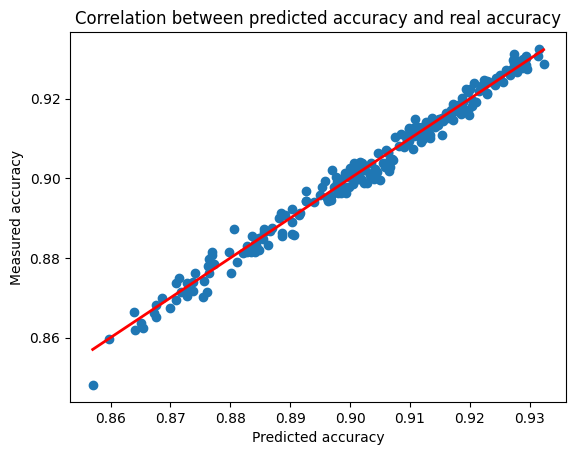

In [23]:
predicted_accuracies = []
ground_truth_accuracies = []
acc_predictor = acc_predictor.to("cuda:0")
acc_predictor.eval()
with torch.no_grad():
    with tqdm(total=len(valid_loader), desc="Val") as t:
        for (data, label) in valid_loader:
            data = data.to(device)
            label = label.to(device)
            pred = acc_predictor(data)
            predicted_accuracies += pred.cpu().numpy().tolist()
            ground_truth_accuracies += label.cpu().numpy().tolist()
            if len(predicted_accuracies) > 200:
                break
plt.scatter(predicted_accuracies, ground_truth_accuracies)
# draw y = x
min_acc, max_acc = min(predicted_accuracies), max(predicted_accuracies)
plt.plot([min_acc, max_acc], [min_acc, max_acc], c="red", linewidth=2)
plt.xlabel("Predicted accuracy")
plt.ylabel("Measured accuracy")
plt.title("Correlation between predicted accuracy and real accuracy")

## **Part 2. Neural Architecture Search (6 Questions, 65 pts + 10 bonus pts)**



So far, we have defined both the efficiency and accuracy predictors. Let's start fast model specialization with these two powerful predictors!

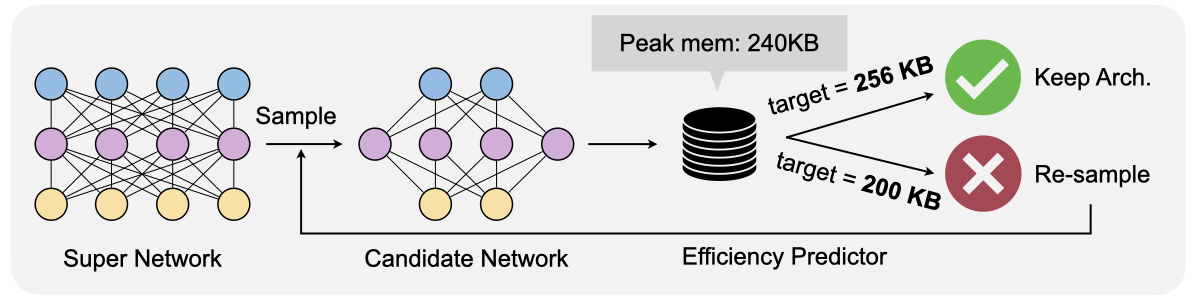

In this part, you are required to implement two typical search algorithms: **random search** and **evolutionary search**. The search algorithm aims to find the model architecture that provides the best accuracy while satisfying the efficiency constraints (e.g., MACs, peak memory).

### Question 5 (5 pts): Complete the following random search agent.

In [37]:
class RandomSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

    def random_valid_sample(self, constraint):
        # randomly sample subnets until finding one that satisfies the constraint
        while True:
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency

    def run_search(self, constraint, n_subnets=100):
        subnet_pool = []
        # sample subnets
        for _ in tqdm(range(n_subnets)):
            sample, efficiency = self.random_valid_sample(constraint)
            subnet_pool.append(sample)
        # predict the accuracy of subnets
        accs = self.accuracy_predictor.predict_acc(subnet_pool)
        ############### YOUR CODE STARTS HERE ###############
        # hint: one line of code
        # get the index of the best subnet
        best_idx =np.argmax(accs.detach().cpu().numpy())
        ############### YOUR CODE ENDS HERE #################
        # return the best subnet
        return accs[best_idx], subnet_pool[best_idx]

### Question 6 (5 pts): Complete the following function.

In [40]:
def search_and_measure_acc(agent, constraint, **kwargs):
    ############### YOUR CODE STARTS HERE ###############
    # hint: call the search function
    best_info =agent.run_search(constraint,**kwargs)
    ############### YOUR CODE ENDS HERE #################
    # get searched subnet
    ofa_network.set_active_subnet(**best_info[1])
    subnet = ofa_network.get_active_subnet().to(device)
    # calibrate bn
    calib_bn(subnet, data_dir, 128, best_info[1]["image_size"])
    # build val loader
    val_loader = build_val_data_loader(data_dir, best_info[1]["image_size"], 128)
    # measure accuracy
    acc = validate(subnet, val_loader)
    # print best_info
    print(f"Accuracy of the selected subnet: {acc}")
    # visualize model architecture
    visualize_subnet(best_info[1])
    return acc, subnet


Random search with constraint: MACs <= 50M


Validate: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s, loss=0.187, top1=93.3]


Accuracy of the selected subnet: 93.27543427346657


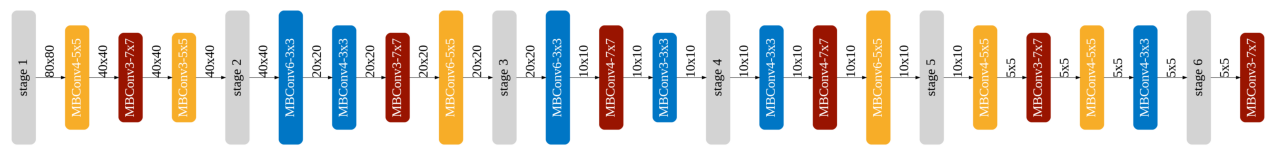

Random search with constraint: MACs <= 100M


Validate: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s, loss=0.188, top1=93.5]


Accuracy of the selected subnet: 93.5483871270646


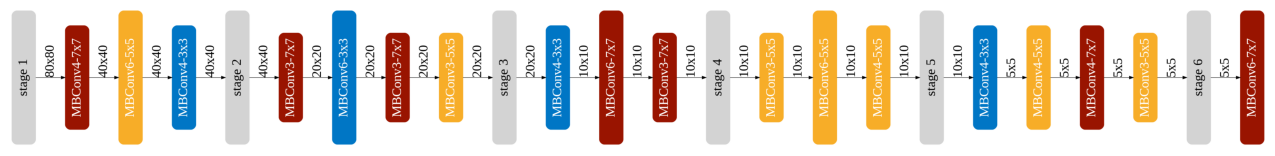

Random search with constraint: Peak memory <= 256KB


Validate: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s, loss=0.193, top1=93.2]


Accuracy of the selected subnet: 93.20099258612167


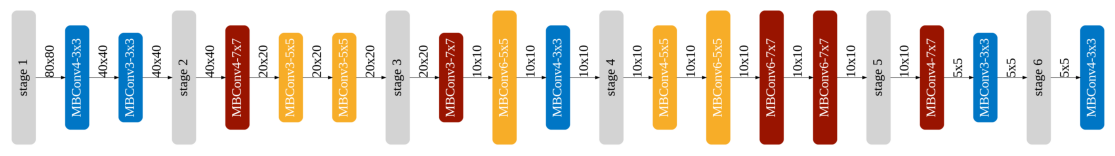

Random search with constraint: Peak memory <= 512KB


Validate: 100%|██████████| 32/32 [00:10<00:00,  2.91it/s, loss=0.192, top1=93.5]


Accuracy of the selected subnet: 93.5483871270646


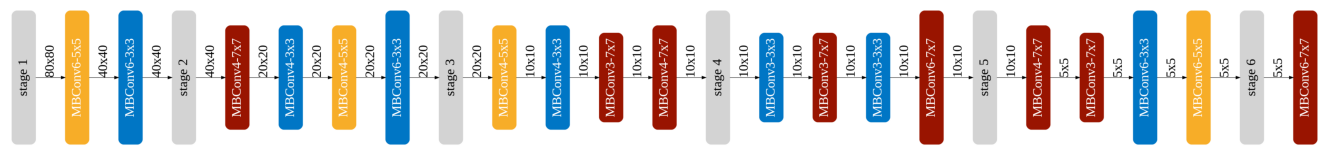

In [41]:
random.seed(1)
np.random.seed(1)
nas_agent = RandomSearcher(efficiency_predictor, acc_predictor)
# MACs-constrained search
subnets_rs_macs = {}
for millonMACs in [50, 100]:
    search_constraint = dict(millonMACs=millonMACs)
    print(f"Random search with constraint: MACs <= {millonMACs}M")
    subnets_rs_macs[millonMACs] = search_and_measure_acc(nas_agent, search_constraint, n_subnets=300)

# memory-constrained search
subnets_rs_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Random search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_rs_memory[KBPeakMemory] = search_and_measure_acc(nas_agent, search_constraint, n_subnets=300)


### Question7 (20 pts): Complete the following evolutionary search agent.



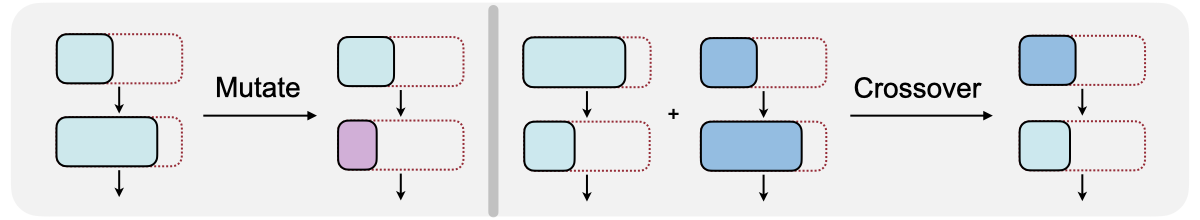

Now you have succesfully implemented the random search algorithm. In this part, we will implement a more sample-efficient search algorithm, evolutionary search. Evolutionary search is inspired by the evolution algorithm (or genetic algorithm). A **population** of sub-networks are first sampled from the design space. Then, in each **generation**, we perform random mutation and crossover operations as is shown in the figure above. The sub-networks with highest accuracy will be kept, and this process will be repeated until the number of generations reaches `max_time_budget`. Similar to the random search, throughout the search process, all sub-networks that cannot satisfy the efficiency constraint will be discarded.


In [47]:
class EvolutionSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor, **kwargs):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

        # evolution hyper-parameters
        self.arch_mutate_prob = kwargs.get("arch_mutate_prob", 0.1)
        self.resolution_mutate_prob = kwargs.get("resolution_mutate_prob", 0.5)
        self.population_size = kwargs.get("population_size", 100)
        self.max_time_budget = kwargs.get("max_time_budget", 500)
        self.parent_ratio = kwargs.get("parent_ratio", 0.25)
        self.mutation_ratio = kwargs.get("mutation_ratio", 0.5)

    def update_hyper_params(self, new_param_dict):
        self.__dict__.update(new_param_dict)

    def random_valid_sample(self, constraint):
        # randomly sample subnets until finding one that satisfies the constraint
        while True:
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency

    def mutate_sample(self, sample, constraint):
        while True:
            new_sample = copy.deepcopy(sample)

            self.accuracy_predictor.arch_encoder.mutate_resolution(new_sample, self.resolution_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_width(new_sample, self.arch_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_arch(new_sample, self.arch_mutate_prob)

            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency

    def crossover_sample(self, sample1, sample2, constraint):
        while True:
            new_sample = copy.deepcopy(sample1)
            for key in new_sample.keys():
                if not isinstance(new_sample[key], list):
                    ############### YOUR CODE STARTS HERE ###############
                    # hint: randomly choose the value from sample1[key] and sample2[key], random.choice
                    new_sample[key] = random.choice([sample1[key],sample2[key]])
                    ############### YOUR CODE ENDS HERE #################
                else:
                    for i in range(len(new_sample[key])):
                        ############### YOUR CODE STARTS HERE ###############
                        new_sample[key][i] = random.choice([sample1[key][i],sample2[key][i]])
                        ############### YOUR CODE ENDS HERE #################

            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency

    def run_search(self, constraint, **kwargs):
        self.update_hyper_params(kwargs)

        mutation_numbers = int(round(self.mutation_ratio * self.population_size))
        parents_size = int(round(self.parent_ratio * self.population_size))

        best_valids = [-100]
        population = []  # (acc, sample) tuples
        child_pool = []
        best_info = None
        # generate random population
        for _ in range(self.population_size):
            sample, efficiency = self.random_valid_sample(constraint)
            child_pool.append(sample)

        accs = self.accuracy_predictor.predict_acc(child_pool)
        for i in range(self.population_size):
            population.append((accs[i].item(), child_pool[i]))

        # evolving the population
        with tqdm(total=self.max_time_budget) as t:
            for i in range(self.max_time_budget):
                ############### YOUR CODE STARTS HERE ###############
                # hint: sort the population according to the acc (descending order)
                population = sorted(population,reverse=True,key=lambda x: x[0])
                ############### YOUR CODE ENDS HERE #################

                ############### YOUR CODE STARTS HERE ###############
                # hint: keep topK samples in the population, K = parents_size
                # the others are discarded.
                population = population[0:parents_size]
                ############### YOUR CODE ENDS HERE #################

                # update best info
                acc = population[0][0]
                if acc > best_valids[-1]:
                    best_valids.append(acc)
                    best_info = population[0]
                else:
                    best_valids.append(best_valids[-1])

                child_pool = []
                for j in range(mutation_numbers):
                    # randomly choose a sample
                    par_sample = population[np.random.randint(parents_size)][1]
                    # mutate this sample
                    new_sample, efficiency = self.mutate_sample(par_sample, constraint)
                    child_pool.append(new_sample)

                for j in range(self.population_size - mutation_numbers):
                    # randomly choose two samples
                    par_sample1 = population[np.random.randint(parents_size)][1]
                    par_sample2 = population[np.random.randint(parents_size)][1]
                    # crossover
                    new_sample, efficiency = self.crossover_sample(
                        par_sample1, par_sample2, constraint
                    )
                    child_pool.append(new_sample)
                # predict accuracy with the accuracy predictor
                accs = self.accuracy_predictor.predict_acc(child_pool)
                for j in range(self.population_size):
                    population.append((accs[j].item(), child_pool[j]))

                t.update(1)

        return best_info

### Question 8 (10pts): Run evolutionary search and tune evo_params to optimize the results. Describe your findings.


Evolutionary search with constraint: MACs <= 50M


Validate: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s, loss=0.197, top1=93.1]


Accuracy of the selected subnet: 93.10173693862801


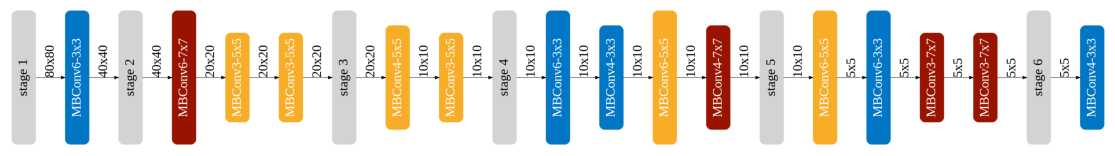

Evolutionary search with constraint: MACs <= 100M


Validate: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s, loss=0.187, top1=93.4]


Accuracy of the selected subnet: 93.4243176481564


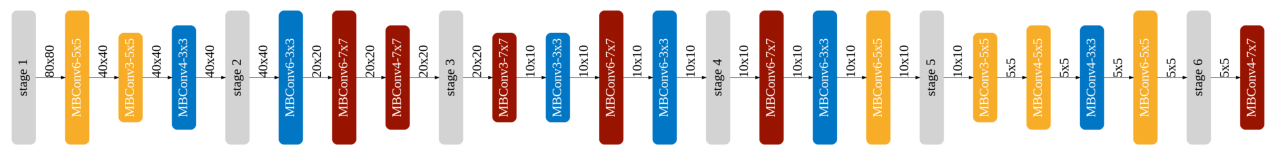

Evolutionary search with constraint: Peak memory <= 256KB


Validate: 100%|██████████| 32/32 [00:10<00:00,  3.08it/s, loss=0.197, top1=92.9]


Accuracy of the selected subnet: 92.87841194096038


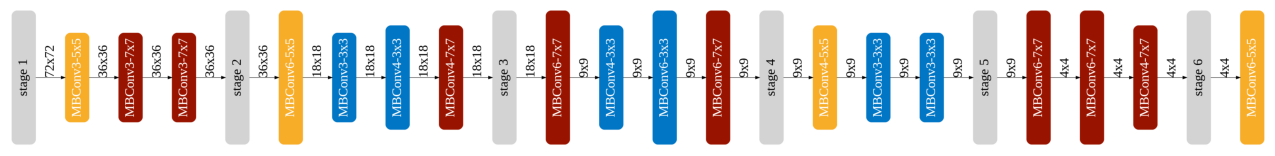

Evolutionary search with constraint: Peak memory <= 512KB


Validate: 100%|██████████| 32/32 [00:10<00:00,  3.11it/s, loss=0.198, top1=92.8]


Accuracy of the selected subnet: 92.80397018924836


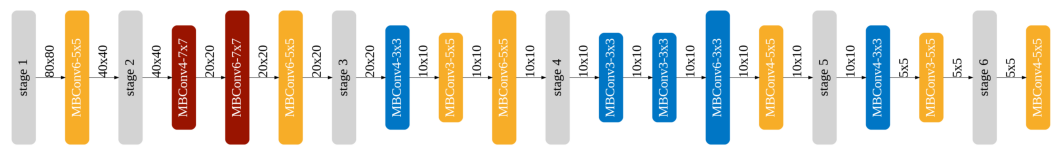

In [48]:
random.seed(1)
np.random.seed(1)

# hint: tune hyper-parameters below
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 10,
    'parent_ratio': 0.1,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)
# MACs-constrained search
subnets_evo_macs = {}
for millonMACs in [50, 100]:
    search_constraint = dict(millionMACs=millonMACs)
    print(f"Evolutionary search with constraint: MACs <= {millonMACs}M")
    subnets_evo_macs[millonMACs] = search_and_measure_acc(nas_agent, search_constraint)

# memory-constrained search
subnets_evo_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Evolutionary search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_evo_memory[KBPeakMemory] = search_and_measure_acc(nas_agent, search_constraint)


### Question 9 (15 pts + 10 pts bonus): Run evolutionary search under real-world constraints.

In real-world applications, we may have multiple efficiency constraints: https://blog.tensorflow.org/2019/10/visual-wake-words-with-tensorflow-lite_30.html.
Use evolutionary search to find models that satisfy the following constraints:
- [15 pts] 250 KB, 60M MACs (acc >= 92.5% to get the full credit)
- [10 pts, **bonus**] 200KB, 30M MACs (acc >= 90% to get the full credit)

Hint: You do not have to use the same `evo_params` for these two tasks.

Evolution search with constraint: MACs <= 60M, peak memory <= 250KB


Validate: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s, loss=0.195, top1=93.2]


Accuracy of the selected subnet: 93.17617869034002


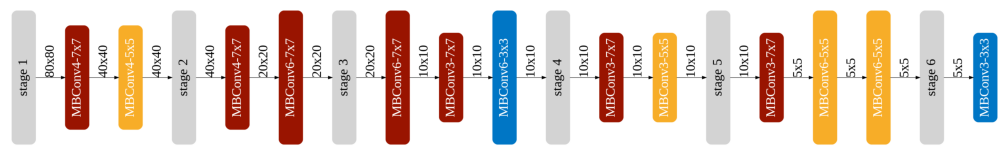

Evolution search finished!


In [49]:
random.seed(1)
np.random.seed(1)
# hint: tune hyper-parameters below
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 10,
    'parent_ratio': 0.1,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [60, 250]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

Evolution search with constraint: MACs <= 60M, peak memory <= 128KB


Validate: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s, loss=0.2, top1=92.9]


Accuracy of the selected subnet: 92.85359799217053


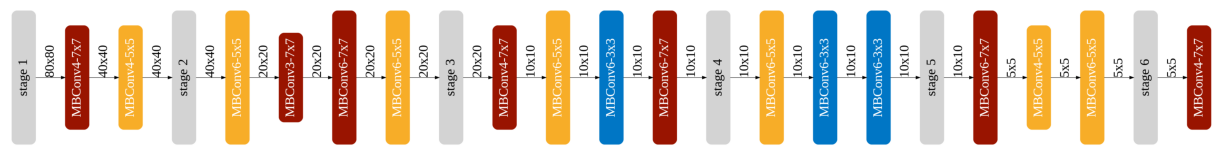

Evolution search finished!


In [57]:
random.seed(1)
np.random.seed(1)
# hint: tune hyper-parameters below
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 50,
    'parent_ratio': 0.2,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [60, 128]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

### Question 10 (10 pts): Is it possible to find a subnet with the following efficiency constraints in the current design space?
- A: The activation size of the subnet is **at most 256KB** and the MACs of the subnet is **at most 15M**.

YES
- B: The activation size of the subnet is **at most 64 KB**.

NO
